In [1]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import optuna
from sklearn.feature_selection import RFE
from scipy.stats import entropy

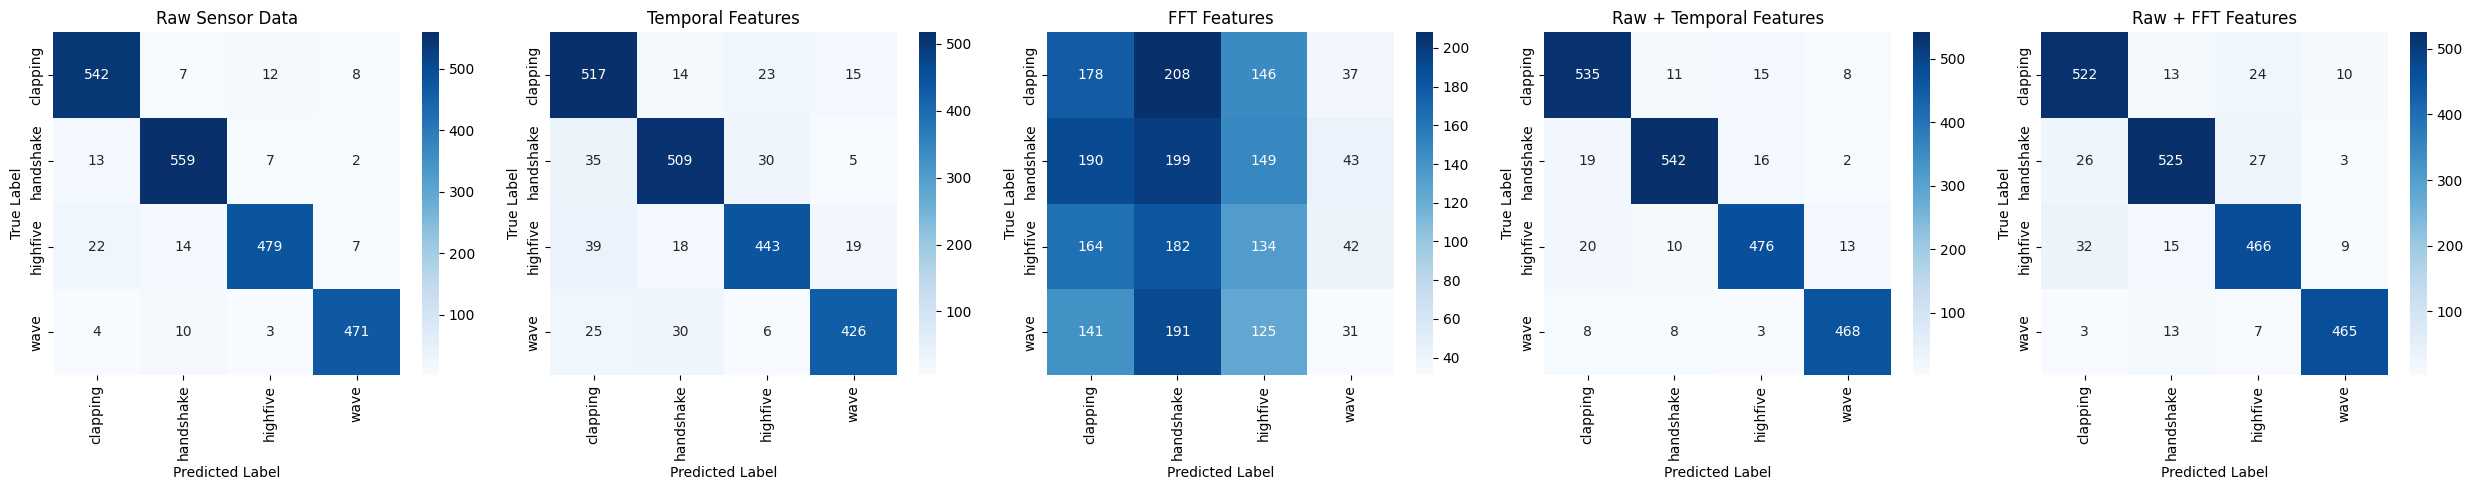

Classification Report - Raw Sensor Data
              precision    recall  f1-score   support

    clapping       0.93      0.95      0.94       569
   handshake       0.95      0.96      0.95       581
    highfive       0.96      0.92      0.94       522
        wave       0.97      0.97      0.97       488

    accuracy                           0.95      2160
   macro avg       0.95      0.95      0.95      2160
weighted avg       0.95      0.95      0.95      2160



Classification Report - Temporal Features
              precision    recall  f1-score   support

    clapping       0.84      0.91      0.87       569
   handshake       0.89      0.88      0.89       579
    highfive       0.88      0.85      0.87       519
        wave       0.92      0.87      0.89       487

    accuracy                           0.88      2154
   macro avg       0.88      0.88      0.88      2154
weighted avg       0.88      0.88      0.88      2154



Classification Report - FFT Features
       

In [2]:
combined_accel_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_data/Combined_accelerometer_100min.csv')
combined_gyro_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_data/Combined_gyroscope_100min.csv')
combined_linear_accel_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_data/Combined_linear_accelerometer_100min.csv')
combined_magnetometer_data = pd.read_csv('/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_data/Combined_magnetometer_100min.csv')


# Combine all data into one dataframe
combined_data = pd.merge(combined_accel_data, combined_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_data = pd.merge(combined_data, combined_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_data = pd.merge(combined_data, combined_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

# Remove duplicate 'label' columns keeping only the first occurrence
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]

# Ensure there are no NaN values
combined_data.dropna(inplace=True)

# Assuming the target column is named 'label' and is present in all files
target = 'label'

# Define feature columns (excluding time and target columns)
feature_columns = combined_data.columns.difference(['time', target])

# Split the data into features and target
X = combined_data[feature_columns]
y = combined_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7777)

# Train and evaluate function
def train_and_evaluate(X_train, y_train, X_test, y_test):
    rf_model = RandomForestClassifier(
        n_estimators=9,
        max_depth=19,
        min_samples_split=3,
        min_samples_leaf=7,
        criterion='log_loss',
        max_features='log2',
        random_state=24
    )
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['clapping', 'handshake', 'highfive', 'wave'])
    
    return rf_model, f1, conf_matrix, class_report

# Model 1: Raw Sensor Data
rf_model_raw, f1_raw, conf_matrix_raw, class_report_raw = train_and_evaluate(X_train, y_train, X_test, y_test)

# Model 2: Temporal Features
def add_time_features(df, lags, rolling_windows):
    for feature in df.columns:
        if feature not in ['time', 'label']:
            for lag in lags:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in rolling_windows:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()
                df[f'{feature}_ewma'] = df[feature].ewm(span=10).mean()
    return df

lags = [3]
rolling_windows = [7]
X_train_temp = add_time_features(X_train.copy(), lags, rolling_windows).dropna()
X_test_temp = add_time_features(X_test.copy(), lags, rolling_windows).dropna()

# Align y_train and y_test with the modified X_train_temp and X_test_temp
y_train_temp = y_train.loc[X_train_temp.index]
y_test_temp = y_test.loc[X_test_temp.index]

rf_model_temp, f1_temp, conf_matrix_temp, class_report_temp = train_and_evaluate(X_train_temp, y_train_temp, X_test_temp, y_test_temp)



def compute_fft_features(df, columns):
    fft_features = {}
    for col in columns:
        fft_vals = fft(df[col].values)
        freqs = np.fft.fftfreq(len(fft_vals))
        magnitudes = np.abs(fft_vals)
        
        # Basic FFT Features
        fft_features[f'{col}_fft_real'] = np.real(fft_vals)
        fft_features[f'{col}_fft_imag'] = np.imag(fft_vals)
        fft_features[f'{col}_fft_abs'] = magnitudes
        
#         # Additional FFT Features
#         # Peak Frequency
#         peak_freq = freqs[np.argmax(magnitudes)]
#         fft_features[f'{col}_fft_peak_freq'] = peak_freq
        
#         # Spectral Centroid
#         spectral_centroid = np.sum(freqs * magnitudes) / np.sum(magnitudes)
#         fft_features[f'{col}_fft_spectral_centroid'] = spectral_centroid
        
#         # Spectral Bandwidth
#         spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * magnitudes) / np.sum(magnitudes))
#         fft_features[f'{col}_fft_spectral_bandwidth'] = spectral_bandwidth
        
#         # Dominant Frequencies (top 5)
#         dominant_freq_indices = np.argsort(magnitudes)[-5:]
#         for i, idx in enumerate(dominant_freq_indices):
#             fft_features[f'{col}_fft_dominant_freq_{i+1}'] = freqs[idx]
    
    return pd.DataFrame(fft_features, index=df.index)


fft_features_train = compute_fft_features(X_train, feature_columns).dropna()
fft_features_test = compute_fft_features(X_test, feature_columns).dropna()

# Align y_train and y_test with the modified fft_features_train and fft_features_test
y_train_fft = y_train.loc[fft_features_train.index]
y_test_fft = y_test.loc[fft_features_test.index]

rf_model_fft, f1_fft, conf_matrix_fft, class_report_fft = train_and_evaluate(fft_features_train, y_train_fft, fft_features_test, y_test_fft)

# Model 4: Raw Sensor Data + Temporal Features
X_train_temp_full = pd.concat([X_train, X_train_temp], axis=1).dropna()
X_test_temp_full = pd.concat([X_test, X_test_temp], axis=1).dropna()

# Align y_train and y_test with the modified X_train_temp_full and X_test_temp_full
y_train_temp_full = y_train.loc[X_train_temp_full.index]
y_test_temp_full = y_test.loc[X_test_temp_full.index]

rf_model_temp_full, f1_temp_full, conf_matrix_temp_full, class_report_temp_full = train_and_evaluate(X_train_temp_full, y_train_temp_full, X_test_temp_full, y_test_temp_full)

# Model 5: Raw Sensor Data + FFT Features
fft_features_train_full = pd.concat([X_train, fft_features_train], axis=1).dropna()
fft_features_test_full = pd.concat([X_test, fft_features_test], axis=1).dropna()

# Align y_train and y_test with the modified fft_features_train_full and fft_features_test_full
y_train_fft_full = y_train.loc[fft_features_train_full.index]
y_test_fft_full = y_test.loc[fft_features_test_full.index]

rf_model_fft_full, f1_fft_full, conf_matrix_fft_full, class_report_fft_full = train_and_evaluate(fft_features_train_full, y_train_fft_full, fft_features_test_full, y_test_fft_full)

# Plot Confusion Matrices Side by Side
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

confusion_matrices = [conf_matrix_raw, conf_matrix_temp, conf_matrix_fft, conf_matrix_temp_full, conf_matrix_fft_full]
titles = [
    'Raw Sensor Data',
    'Temporal Features',
    'FFT Features',
    'Raw + Temporal Features',
    'Raw + FFT Features'
]

for ax, conf_matrix, title in zip(axes, confusion_matrices, titles):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['clapping', 'handshake', 'highfive', 'wave'], yticklabels=['clapping', 'handshake', 'highfive', 'wave'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)

plt.tight_layout()
plt.show()

# Display Classification Reports Side by Side
classification_reports = [
    class_report_raw,
    class_report_temp,
    class_report_fft,
    class_report_temp_full,
    class_report_fft_full
]

for title, report in zip(titles, classification_reports):
    print(f"Classification Report - {title}")
    print(report)
    print("\n")

In [3]:
def extract_sensor_type(feature_name):
    if 'X (m/s^2)' in feature_name or 'Y (m/s^2)' in feature_name or 'Z (m/s^2)' in feature_name:
        if 'lin_acc' in feature_name:
            return 'Linear Accelerometer'
        else:
            return 'Accelerometer'
    elif 'acc' in feature_name and 'lin' not in feature_name:
        return 'Accelerometer'
    elif 'gyro' in feature_name or 'rad/s' in feature_name:
        return 'Gyroscope'
    elif 'lin_acc' in feature_name:
        return 'Linear Accelerometer'
    elif 'µT' in feature_name:
        return 'Magnetometer'
    elif 'rolling' in feature_name or 'lag' in feature_name or 'ewma' in feature_name:
        return 'Time-Based Feature'
    elif 'fft' in feature_name:
        return 'FFT Feature'
    else:
        return 'Unknown'


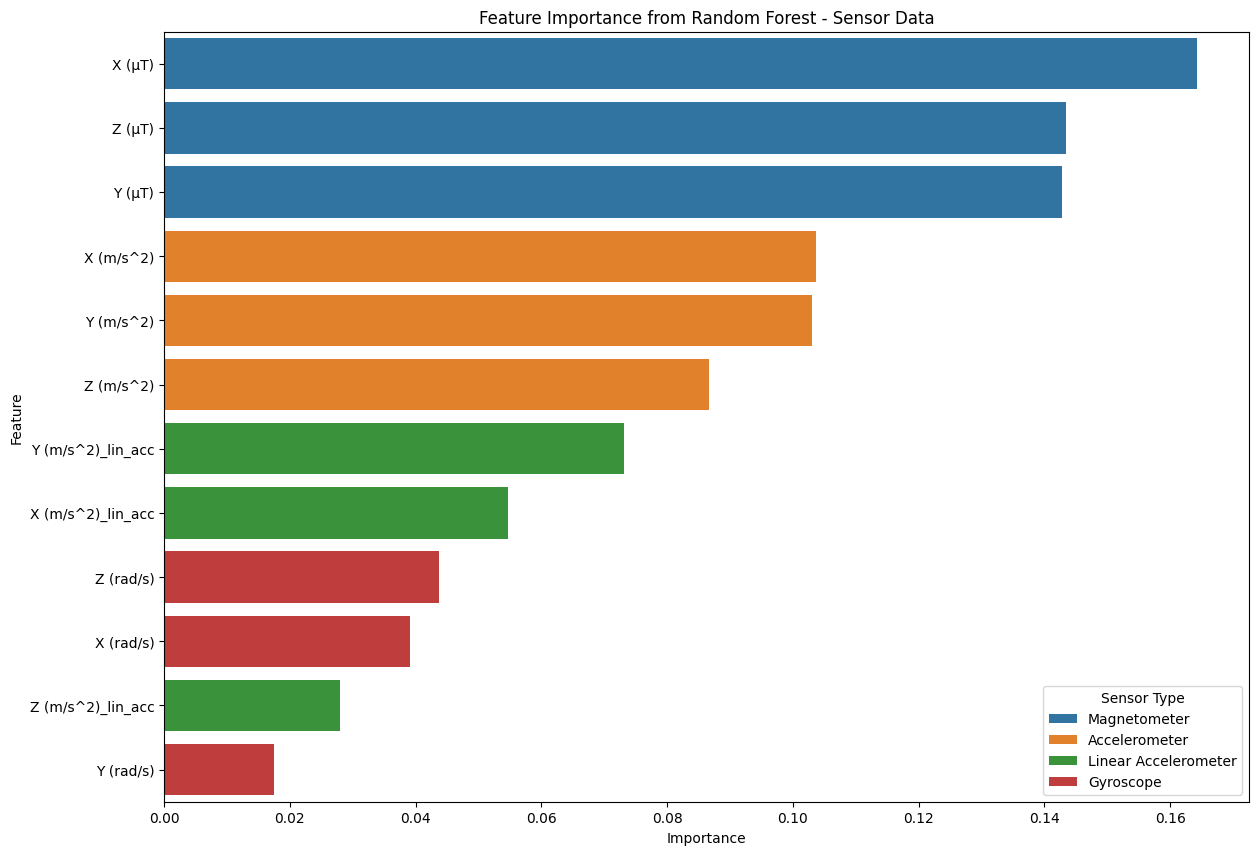

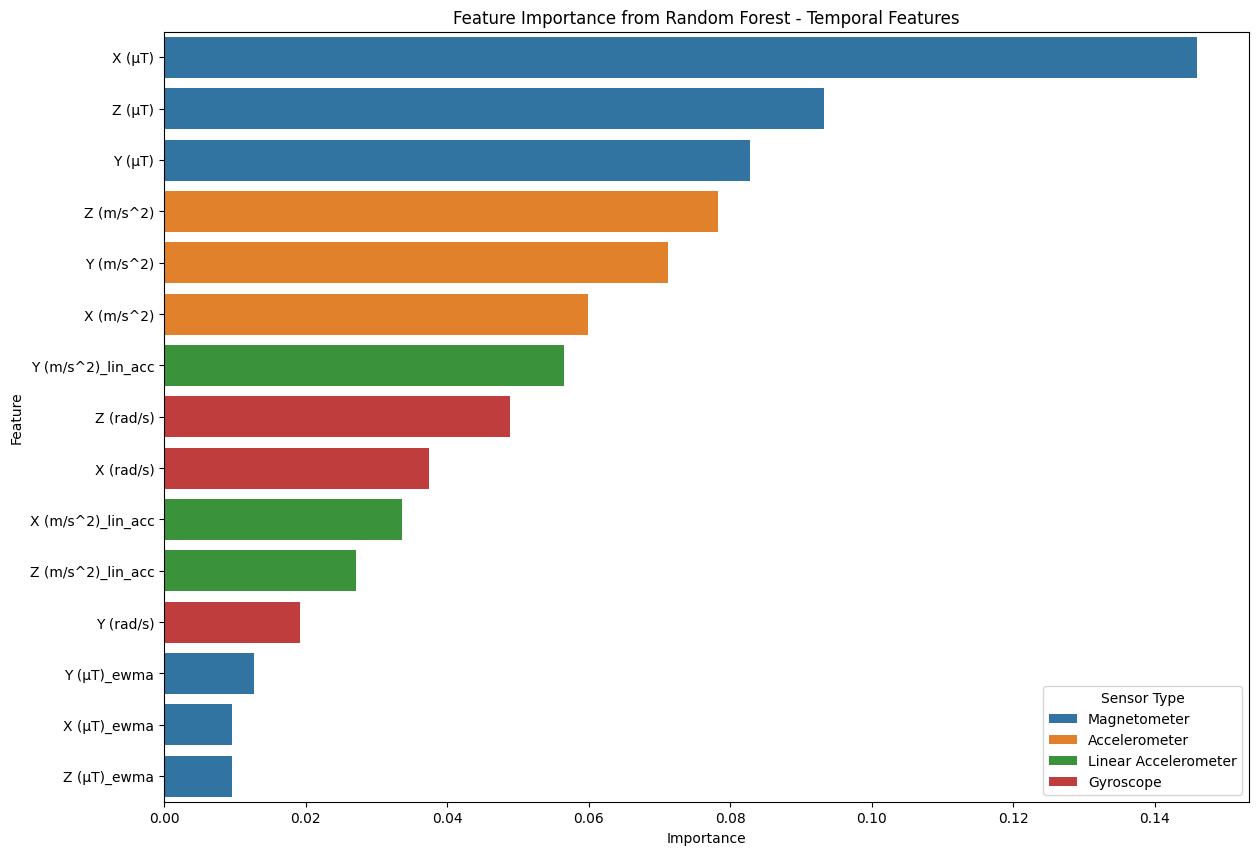

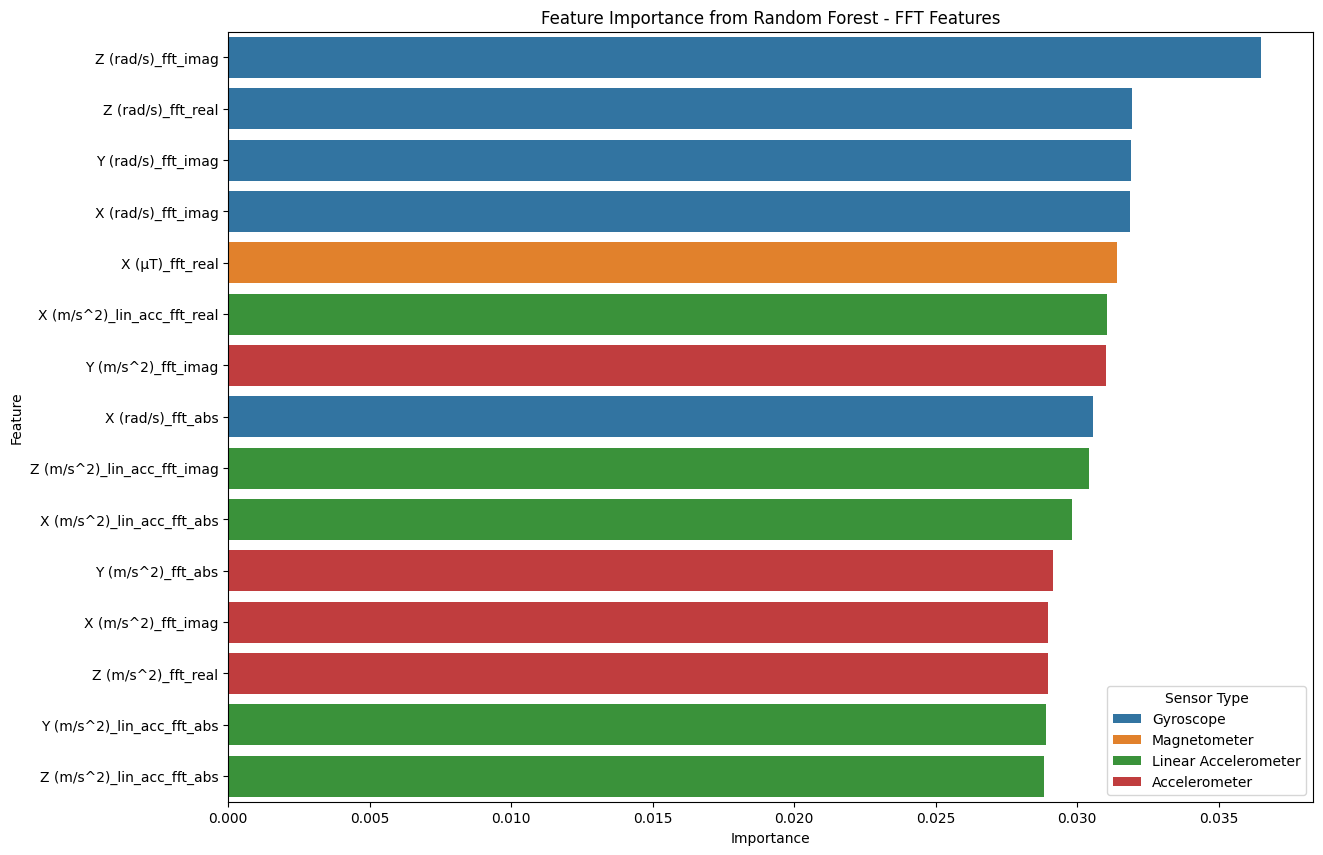

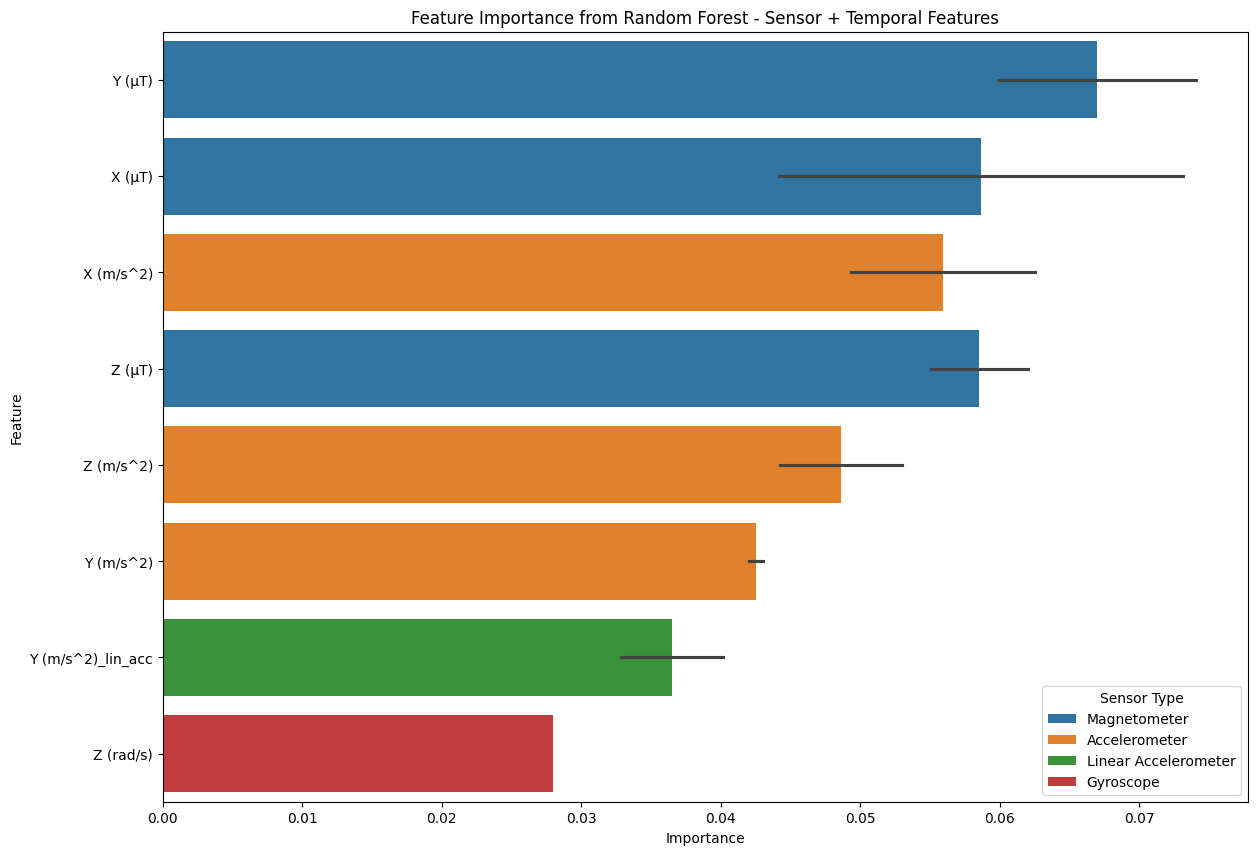

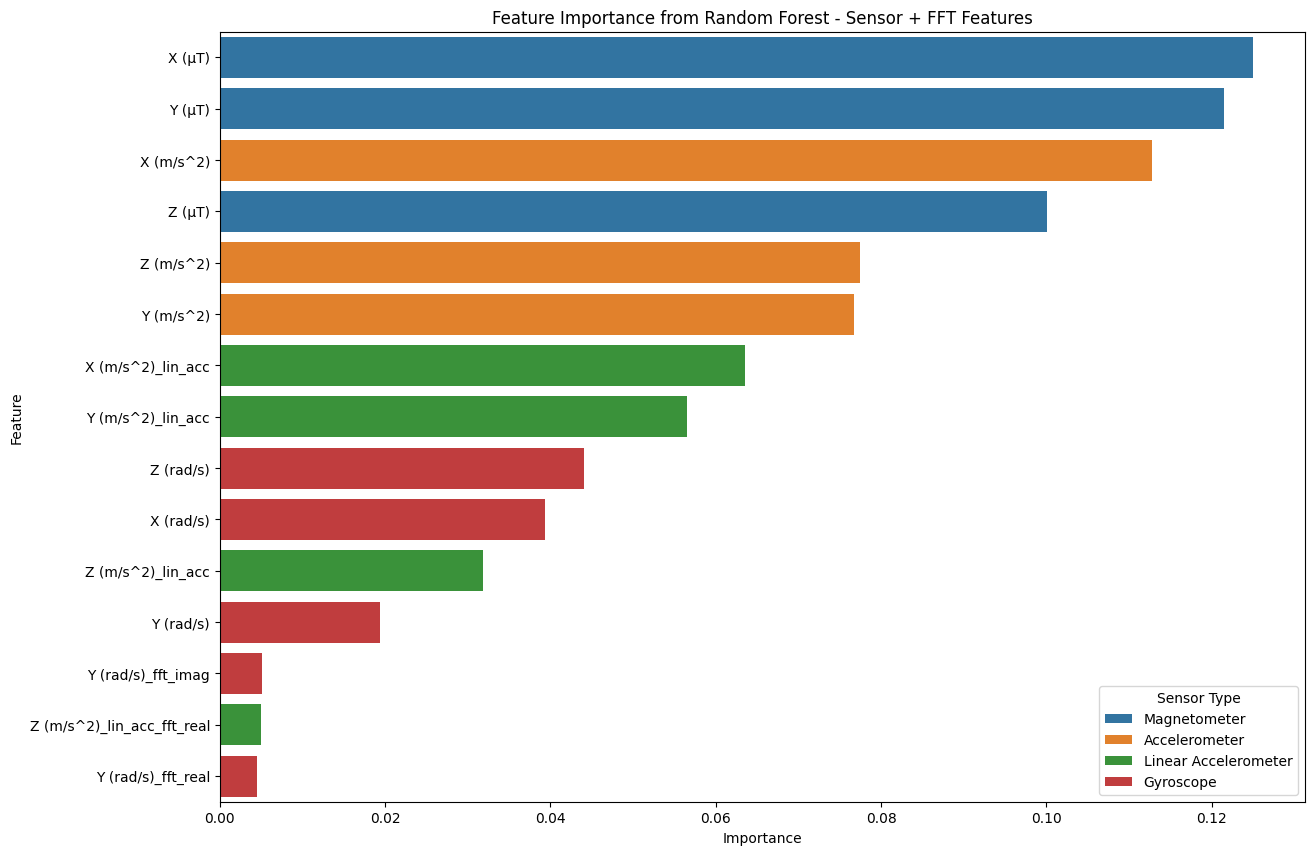

In [4]:
def plot_feature_importance(rf_model, feature_columns, title, top_n=15):
    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Correctly map the feature names to the features used in the model
    feature_names = feature_columns.tolist()

    # Ensure feature_names matches the actual features used in the model
    assert len(feature_names) == len(feature_importances), "Mismatch between feature names and importances lengths."

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Assign sensor type and feature type to each feature
    importance_df['Sensor'] = importance_df['Feature'].apply(extract_sensor_type)
    importance_df['Feature Type'] = importance_df['Feature'].apply(lambda x: 'Temporal' if 'lag' in x or 'rolling' in x or 'ewma' in x else ('FFT' if 'fft' in x else 'Sensor'))

    # Plot feature importances with sensor type and feature type indicated
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', hue='Sensor', data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.legend(title='Sensor Type')
    plt.show()
    
# For Sensor Data Model
plot_feature_importance(rf_model_raw, feature_columns, 'Feature Importance from Random Forest - Sensor Data', top_n=15)

# For Temporal Features Model
feature_columns_temp = X_train_temp.columns
plot_feature_importance(rf_model_temp, feature_columns_temp, 'Feature Importance from Random Forest - Temporal Features', top_n=15)

# For FFT Features Model
feature_columns_fft = fft_features_train.columns
plot_feature_importance(rf_model_fft, feature_columns_fft, 'Feature Importance from Random Forest - FFT Features', top_n=15)

# For Sensor + Temporal Features Model
feature_columns_temp_sensor = X_train_temp_full.columns
plot_feature_importance(rf_model_temp_full, feature_columns_temp_sensor, 'Feature Importance from Random Forest - Sensor + Temporal Features', top_n=15)

# For Sensor + FFT Features Model
feature_columns_fft_sensor = fft_features_train_full.columns
plot_feature_importance(rf_model_fft_full, feature_columns_fft_sensor, 'Feature Importance from Random Forest - Sensor + FFT Features', top_n=15)
